In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Cleaned_deathCnt/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files['서울']
data['dailyCnt'] = data['defCnt'].diff().fillna(0)
data

,deathCnt,defCnt,gubun,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,stdDay,dailyCnt
0,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-20,0.0
1,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-21,0.0
2,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-22,0.0
3,0,0,서울,Seoul,0.0,0,0,0,0,0.0,2020-01-23,0.0
4,0,1,서울,Seoul,1.0,0,1,0,1,0.0,2020-01-24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1214,6471,6162486,서울,Seoul,4329.0,0,0,4371,0,65361.0,2023-05-20,4329.0
1215,6473,6166682,서울,Seoul,4196.0,0,0,4195,1,65406.0,2023-05-21,4196.0
1216,6476,6167953,서울,Seoul,1271.0,0,0,1271,0,65419.0,2023-05-22,1271.0
1217,6477,6173315,서울,Seoul,5362.0,0,0,5359,3,65476.0,2023-05-23,5362.0


In [3]:
learning_rates_list = [1e-3, 1e-4]
patiences_list = [20, 50]
num_layers_list = [1, 2, 4]
batch_sizes_list = [32, 64, 128]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25, 0.5]
criterions_list = [nn.MSELoss(), criterion2, criterion3]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        for criterion in criterions_list:
                            hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout, criterion]
                            i += 1
                        
print(i)

648


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'dailyCnt')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

mape_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '서울_seq2seq_LSTM', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    criterion = hyperparameter[6]
    print('----------------------------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout, 'criterion:', criterion)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 800, 60, 7, batch_size, 'mtm')
    

    model = LSTM_encoder_decoder(input_size = input_size,
                                hidden_size = hidden_size,
                                num_layers = num_layers, 
                                dropout = dropout, 
                                device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_Many(train_loader, 
                                                   test_loader, 
                                                   model, 
                                                   criterion, 
                                                   optimizer, 
                                                   num_epochs, 
                                                   patience,
                                                   device)
    
    label_y, predicted, first_label_y, first_predicted = predict_mtm(model, df, x_ss, y_ms, 1151, 7, 0.5, device)
    
    if mape_min > mape(label_y+1, predicted):
        mape_min = mape(label_y+1, predicted)
        best_model['seq2seq_LSTM'] = [mape_min, model, loss_list, epoch, lr, patience, 
                                     num_layers, batch_size, hidden_size, dropout, criterion]

서울_seq2seq_LSTM:   0%|          | 0/648 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 375 loss: 0.000560
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.011661
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 175 loss: 0.002048
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.000909
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 203 loss: 0.008340
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 179 loss: 0.001968
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 410 loss: 0.000199
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 145 loss: 0.008980
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 70 loss: 0.002529
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.000768
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 86 loss: 0.011803
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 84 loss: 0.002557
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 238 loss: 0.000171
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 43 loss: 0.015417
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 96 loss: 0.003295
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 239 loss: 0.000196
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 48 loss: 0.015932
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 155 loss: 0.002010
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 470 loss: 0.000551
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 139 loss: 0.007800
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 169 loss: 0.001519
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 772 loss: 0.000446
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.009499
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 145 loss: 0.001790
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 249 loss: 0.000493
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 240 loss: 0.006855
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 76 loss: 0.001745
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 592 loss: 0.000320
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 126 loss: 0.007512
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 68 loss: 0.001697
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 417 loss: 0.000118
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 122 loss: 0.010947
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 52 loss: 0.002020
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 96 loss: 0.000749
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 77 loss: 0.009226
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.001651
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 369 loss: 0.000689
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 405 loss: 0.007383
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 232 loss: 0.001289
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 729 loss: 0.000387
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 217 loss: 0.008400
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 925 loss: 0.001072
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 677 loss: 0.000155
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 213 loss: 0.006671
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.001216
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 634 loss: 0.000219
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 139 loss: 0.007644
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 143 loss: 0.001267
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 578 loss: 0.000127
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.008136
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.001277
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 439 loss: 0.000229
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 166 loss: 0.006902
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 139 loss: 0.001332
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 201 loss: 0.000897
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.010867
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.002903
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 105 loss: 0.000952
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.015171
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 87 loss: 0.003390
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 77 loss: 0.001097
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 129 loss: 0.013035
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.002920
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 107 loss: 0.001109
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 148 loss: 0.011077
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 237 loss: 0.002788
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 51 loss: 0.001224
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 67 loss: 0.016731
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 252 loss: 0.002393
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 97 loss: 0.001032
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 84 loss: 0.016053
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 88 loss: 0.003401
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 128 loss: 0.000890
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 135 loss: 0.008545
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 182 loss: 0.001597
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 161 loss: 0.000900
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 231 loss: 0.009254
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 173 loss: 0.001569
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.000856
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 135 loss: 0.010033
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 176 loss: 0.001816
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 105 loss: 0.000980
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 156 loss: 0.008828
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.001891
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 282 loss: 0.000261
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.009621
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.001686
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 273 loss: 0.000361
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 82 loss: 0.011345
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 90 loss: 0.001859
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 115 loss: 0.000940
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.008154
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 182 loss: 0.001387
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 191 loss: 0.000852
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 224 loss: 0.008741
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.001387
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 254 loss: 0.000554
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 220 loss: 0.007240
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 157 loss: 0.001338
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.000901
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 102 loss: 0.011146
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.001443
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 387 loss: 0.000190
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 95 loss: 0.009156
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 176 loss: 0.001309
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.000348
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 185 loss: 0.008160
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.001407
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 72 loss: 0.001230
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 101 loss: 0.017225
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 112 loss: 0.003095
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 63 loss: 0.001640
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 109 loss: 0.013949
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 123 loss: 0.003631
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 148 loss: 0.000978
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.016542
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 159 loss: 0.002770
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.000915
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 66 loss: 0.015313
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.002716
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.001183
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 123 loss: 0.018536
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 60 loss: 0.003273
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 126 loss: 0.001233
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 92 loss: 0.017791
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 82 loss: 0.003276
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 112 loss: 0.001036
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 160 loss: 0.012448
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 208 loss: 0.001888
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 143 loss: 0.001012
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 149 loss: 0.011663
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 134 loss: 0.001826
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.000953
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 118 loss: 0.012318
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.001777
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.000877
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 110 loss: 0.013424
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.002278
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 124 loss: 0.000936
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 140 loss: 0.009799
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 115 loss: 0.001655
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 171 loss: 0.000738
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 130 loss: 0.011024
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 173 loss: 0.001978
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 156 loss: 0.000887
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 137 loss: 0.011306
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 180 loss: 0.001588
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 172 loss: 0.000922
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 294 loss: 0.009137
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 193 loss: 0.001615
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 172 loss: 0.000761
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.009306
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 138 loss: 0.001403
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.000828
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 172 loss: 0.009116
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.001431
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 162 loss: 0.000873
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 126 loss: 0.009344
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 119 loss: 0.001395
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 166 loss: 0.000728
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 111 loss: 0.010526
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 121 loss: 0.001659
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1172 loss: 0.000193
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 209 loss: 0.009059
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 235 loss: 0.002164
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 655 loss: 0.000300
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 424 loss: 0.007690
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 398 loss: 0.002133
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 636 loss: 0.000219
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 181 loss: 0.010168
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 238 loss: 0.002190
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 575 loss: 0.000192
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 255 loss: 0.008334
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 132 loss: 0.002427
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 329 loss: 0.000187
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 342 loss: 0.005826
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 115 loss: 0.002398
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 508 loss: 0.000113
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 494 loss: 0.004597
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 446 loss: 0.001151
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1294 loss: 0.000188
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 431 loss: 0.007645
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 531 loss: 0.001229
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 993 loss: 0.000372
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 197 loss: 0.009055
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 420 loss: 0.001282
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1203 loss: 0.000040
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 325 loss: 0.006982
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 431 loss: 0.001113
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1058 loss: 0.000144
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 494 loss: 0.005241
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 564 loss: 0.000926
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 522 loss: 0.000102
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.007509
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 433 loss: 0.000848
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 635 loss: 0.000070
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 260 loss: 0.009925
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 572 loss: 0.000759
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1288 loss: 0.000254
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1334 loss: 0.006740
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 973 loss: 0.001313
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1614 loss: 0.000169
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 634 loss: 0.007656
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1980 loss: 0.001072
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1471 loss: 0.000081
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 970 loss: 0.006424
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1634 loss: 0.000613
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1477 loss: 0.000040
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 856 loss: 0.005199
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 754 loss: 0.000933
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 788 loss: 0.000071
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 535 loss: 0.005329
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1114 loss: 0.000464
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1020 loss: 0.000039
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 522 loss: 0.004965
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 588 loss: 0.000692
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 735 loss: 0.000439
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 249 loss: 0.010736
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 312 loss: 0.002131
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 259 loss: 0.000859
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 339 loss: 0.009872
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 295 loss: 0.001833
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 649 loss: 0.000122
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 548 loss: 0.006325
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 533 loss: 0.001469
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 661 loss: 0.000187
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 435 loss: 0.008051
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 493 loss: 0.002052
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 520 loss: 0.000132
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 339 loss: 0.006732
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 502 loss: 0.001025
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 477 loss: 0.000144
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 212 loss: 0.012212
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 457 loss: 0.001650
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 789 loss: 0.000381
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 370 loss: 0.008825
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 305 loss: 0.001429
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 708 loss: 0.000529
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 219 loss: 0.009199
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 225 loss: 0.001694
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 769 loss: 0.000158
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 238 loss: 0.009816
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 341 loss: 0.001462
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 830 loss: 0.000150
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 232 loss: 0.010042
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 350 loss: 0.001370
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 567 loss: 0.000378
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 569 loss: 0.004449
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.001504
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 866 loss: 0.000072
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 219 loss: 0.008124
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 478 loss: 0.000867
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 947 loss: 0.000430
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 377 loss: 0.008636
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 300 loss: 0.001355
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 806 loss: 0.000593
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 421 loss: 0.008391
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 487 loss: 0.001211
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 833 loss: 0.000185
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 611 loss: 0.007384
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 539 loss: 0.001020
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 777 loss: 0.000250
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 430 loss: 0.008686
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 463 loss: 0.001207
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 639 loss: 0.000108
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 405 loss: 0.006157
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 715 loss: 0.000748
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 653 loss: 0.000104
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 423 loss: 0.006770
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.001094
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 206 loss: 0.001061
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 148 loss: 0.012748
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 376 loss: 0.002021
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 279 loss: 0.001033
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 354 loss: 0.009535
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 419 loss: 0.002903
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 511 loss: 0.000351
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 411 loss: 0.012059
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 143 loss: 0.002564
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 176 loss: 0.001300
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 349 loss: 0.008831
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 210 loss: 0.002726
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 487 loss: 0.000156
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 196 loss: 0.009488
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 120 loss: 0.002220
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 706 loss: 0.000135
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1010 loss: 0.003187
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 228 loss: 0.002450
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 267 loss: 0.000875
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 515 loss: 0.008559
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 305 loss: 0.001839
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 688 loss: 0.000793
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 294 loss: 0.010382
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 317 loss: 0.001949
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 943 loss: 0.000200
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 526 loss: 0.007221
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 300 loss: 0.001766
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 193 loss: 0.001147
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 256 loss: 0.012421
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 472 loss: 0.001410
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 895 loss: 0.000086
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 264 loss: 0.009373
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 609 loss: 0.001358
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 883 loss: 0.000103
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 774 loss: 0.005328
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 682 loss: 0.000947
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 441 loss: 0.000753
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 313 loss: 0.008369
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 308 loss: 0.001362
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 574 loss: 0.000726
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 365 loss: 0.011091
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 312 loss: 0.001490
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1383 loss: 0.000132
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 362 loss: 0.008254
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 200 loss: 0.001437
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 685 loss: 0.000457
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 403 loss: 0.008765
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 565 loss: 0.001117
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 734 loss: 0.000162
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 284 loss: 0.007718
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 471 loss: 0.001001
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 867 loss: 0.000146
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 291 loss: 0.007690
----------------------------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 731 loss: 0.001066
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 781 loss: 0.000750
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 278 loss: 0.012463
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 665 loss: 0.001786
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 964 loss: 0.000656
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 365 loss: 0.011413
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1137 loss: 0.001733
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1197 loss: 0.000350
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 389 loss: 0.007830
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 772 loss: 0.001582
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 883 loss: 0.000484
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 551 loss: 0.006934
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 747 loss: 0.001624
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 957 loss: 0.000343
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 409 loss: 0.006521
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 666 loss: 0.001439
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 468 loss: 0.000539
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 267 loss: 0.007705
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 521 loss: 0.001549
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1231 loss: 0.000558
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 606 loss: 0.007790
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 832 loss: 0.001485
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1352 loss: 0.000608
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1215 loss: 0.006833
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 903 loss: 0.001409
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 754 loss: 0.000527
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 832 loss: 0.006614
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 367 loss: 0.001490
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1476 loss: 0.000369
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 389 loss: 0.007547
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 340 loss: 0.001555
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1665 loss: 0.000183
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 598 loss: 0.006795
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 314 loss: 0.001513
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1191 loss: 0.000219
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 507 loss: 0.006689
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 613 loss: 0.001257
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1809 loss: 0.000659
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1633 loss: 0.008302
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 714 loss: 0.001462
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2472 loss: 0.000459
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 893 loss: 0.010000
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 855 loss: 0.001393
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2002 loss: 0.000308
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 774 loss: 0.007710
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 893 loss: 0.001296
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1242 loss: 0.000513
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1143 loss: 0.007754
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 708 loss: 0.001305
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2172 loss: 0.000112
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 530 loss: 0.008293
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 702 loss: 0.001125
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2449 loss: 0.000127
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 414 loss: 0.008106
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 959 loss: 0.001052
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 429 loss: 0.001203
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 424 loss: 0.009800
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 514 loss: 0.002215
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 226 loss: 0.001827
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 468 loss: 0.012346
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 309 loss: 0.002582
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 281 loss: 0.000939
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 315 loss: 0.009077
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 226 loss: 0.002296
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 241 loss: 0.001139
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 486 loss: 0.007562
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 481 loss: 0.001900
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 214 loss: 0.000881
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 431 loss: 0.007164
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 321 loss: 0.001821
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 241 loss: 0.000925
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 189 loss: 0.010014
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 246 loss: 0.002182
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 464 loss: 0.001283
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 588 loss: 0.008499
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 652 loss: 0.001789
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 329 loss: 0.001255
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 442 loss: 0.010010
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 752 loss: 0.001858
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 383 loss: 0.000954
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 345 loss: 0.009096
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 406 loss: 0.001641
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 402 loss: 0.000989
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 474 loss: 0.008423
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 353 loss: 0.001654
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 266 loss: 0.000842
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 299 loss: 0.008046
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 422 loss: 0.001392
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 302 loss: 0.000838
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 379 loss: 0.007891
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 250 loss: 0.001534
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 498 loss: 0.001595
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 659 loss: 0.010684
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 457 loss: 0.001717
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 337 loss: 0.001882
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 699 loss: 0.011049
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 532 loss: 0.001934
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 204 loss: 0.001687
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 520 loss: 0.008526
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 337 loss: 0.001512
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 363 loss: 0.001039
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 341 loss: 0.010647
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 388 loss: 0.001684
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 266 loss: 0.000883
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 419 loss: 0.008202
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 354 loss: 0.001320
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 260 loss: 0.000919
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 360 loss: 0.008850
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.001491
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 364 loss: 0.001274
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 236 loss: 0.013960
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 376 loss: 0.002636
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 202 loss: 0.002394
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 326 loss: 0.013953
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 372 loss: 0.002775
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 310 loss: 0.000997
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 176 loss: 0.011283
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 318 loss: 0.002228
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 203 loss: 0.001251
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 368 loss: 0.009821
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 218 loss: 0.002516
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 145 loss: 0.001066
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 162 loss: 0.010817
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 190 loss: 0.002567
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 130 loss: 0.001159
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 128 loss: 0.011921
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 240 loss: 0.002413
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 314 loss: 0.001759
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 507 loss: 0.012262
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 587 loss: 0.001977
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 402 loss: 0.001477
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 458 loss: 0.014102
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 501 loss: 0.002315
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 257 loss: 0.001202
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 321 loss: 0.009794
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 294 loss: 0.001998
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 256 loss: 0.001219
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 357 loss: 0.010440
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 511 loss: 0.001694
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 345 loss: 0.000878
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 225 loss: 0.009488
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 157 loss: 0.001794
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 194 loss: 0.001056
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 216 loss: 0.009515
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 185 loss: 0.001787
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 531 loss: 0.001778
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 629 loss: 0.011523
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 523 loss: 0.002394
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 405 loss: 0.001633
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 729 loss: 0.012965
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 533 loss: 0.002319
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 245 loss: 0.001240
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 449 loss: 0.009999
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 597 loss: 0.001465
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 356 loss: 0.001142
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 407 loss: 0.011005
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 381 loss: 0.001667
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 150 loss: 0.001085
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 382 loss: 0.008541
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 286 loss: 0.001514
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 170 loss: 0.001086
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 355 loss: 0.009542
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 374 loss: 0.001390
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2466 loss: 0.000435
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1047 loss: 0.007254
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1680 loss: 0.001637
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3787 loss: 0.000257
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1262 loss: 0.006440
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1412 loss: 0.001713
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2878 loss: 0.000144
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 711 loss: 0.006394
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1405 loss: 0.001322
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2928 loss: 0.000182
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1210 loss: 0.006042
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1614 loss: 0.001244
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1462 loss: 0.000152
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 603 loss: 0.006013
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 888 loss: 0.001358
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1875 loss: 0.000125
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 984 loss: 0.005564
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 810 loss: 0.001537
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4920 loss: 0.000233
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1636 loss: 0.006534
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1402 loss: 0.001322
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3099 loss: 0.000288
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2130 loss: 0.006012
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1066 loss: 0.001334
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 4852 loss: 0.000049
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1552 loss: 0.006246
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 694 loss: 0.001388
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3881 loss: 0.000111
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1499 loss: 0.006395
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 566 loss: 0.001450
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3279 loss: 0.000044
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 682 loss: 0.006423
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1349 loss: 0.001030
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2905 loss: 0.000048
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 982 loss: 0.006418
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1201 loss: 0.001096
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2372 loss: 0.000500
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2097 loss: 0.007234
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1950 loss: 0.001229
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1792 loss: 0.000651
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1676 loss: 0.007866
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1709 loss: 0.001259
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3843 loss: 0.000105
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1785 loss: 0.006887
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2131 loss: 0.001010
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3284 loss: 0.000177
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1015 loss: 0.007830
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1165 loss: 0.001194
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3283 loss: 0.000041
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2062 loss: 0.005788
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3522 loss: 0.000723
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3697 loss: 0.000055
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1531 loss: 0.006528
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2187 loss: 0.000882
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 856 loss: 0.000854
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 849 loss: 0.008606
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1004 loss: 0.001680
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 749 loss: 0.000917
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 756 loss: 0.009138
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 836 loss: 0.002091
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 638 loss: 0.000697
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 873 loss: 0.006769
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 825 loss: 0.001902
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 729 loss: 0.000722
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 488 loss: 0.007956
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 892 loss: 0.001761
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1266 loss: 0.000223
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 668 loss: 0.007325
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 490 loss: 0.001701
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1786 loss: 0.000122
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 460 loss: 0.006958
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 656 loss: 0.001712
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 541 loss: 0.000922
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1178 loss: 0.007521
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 903 loss: 0.001571
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 881 loss: 0.000854
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 833 loss: 0.008915
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 808 loss: 0.001539
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 651 loss: 0.000743
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 904 loss: 0.007115
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 746 loss: 0.001448
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 433 loss: 0.000854
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1210 loss: 0.006841
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 562 loss: 0.001448
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1767 loss: 0.000177
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 618 loss: 0.006721
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 758 loss: 0.001250
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 424 loss: 0.000755
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 804 loss: 0.006650
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 496 loss: 0.001393
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 699 loss: 0.001016
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1027 loss: 0.008438
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 851 loss: 0.001406
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1061 loss: 0.000948
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 821 loss: 0.010084
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 971 loss: 0.001480
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 953 loss: 0.000695
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 901 loss: 0.007703
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 775 loss: 0.001281
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1092 loss: 0.000619
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 856 loss: 0.007887
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 722 loss: 0.001332
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1688 loss: 0.000248
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 865 loss: 0.007406
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 473 loss: 0.001268
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 998 loss: 0.000556
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 845 loss: 0.007101
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1211 loss: 0.000996
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 736 loss: 0.000912
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 804 loss: 0.009274
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 443 loss: 0.002452
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 516 loss: 0.001159
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 847 loss: 0.008853
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1049 loss: 0.002083
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 366 loss: 0.001017
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 685 loss: 0.008285
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 534 loss: 0.001971
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 621 loss: 0.000860
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 514 loss: 0.008820
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 546 loss: 0.002072
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 207 loss: 0.000983
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 411 loss: 0.008805
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 530 loss: 0.001960
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 322 loss: 0.000983
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 527 loss: 0.008524
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 393 loss: 0.002196
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 737 loss: 0.000998
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 848 loss: 0.009912
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 696 loss: 0.001857
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 596 loss: 0.001002
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 841 loss: 0.009246
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 949 loss: 0.001709
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 393 loss: 0.000934
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 580 loss: 0.008916
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 619 loss: 0.001571
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 556 loss: 0.000850
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 719 loss: 0.008580
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 755 loss: 0.001573
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 580 loss: 0.000803
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 572 loss: 0.008481
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 661 loss: 0.001509
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 274 loss: 0.000981
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 740 loss: 0.007240
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 425 loss: 0.001605
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1112 loss: 0.000944
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 747 loss: 0.011444
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 925 loss: 0.001625
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 820 loss: 0.001162
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 761 loss: 0.012724
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 8  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1002 loss: 0.001617
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 425 loss: 0.000929
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 937 loss: 0.008525
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 476 loss: 0.001492
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 691 loss: 0.000875
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 820 loss: 0.008560
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 16  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 554 loss: 0.001449
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 599 loss: 0.000762
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 563 loss: 0.007910
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.25 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 390 loss: 0.001341
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: MSELoss()


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 340 loss: 0.000902
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion2 at 0x0000024D306077F0>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 684 loss: 0.008312
----------------------------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 128  hidden_size: 32  dropout: 0.5 criterion: <function criterion3 at 0x0000024D30607880>


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 767 loss: 0.001253


In [5]:
best_model

{'seq2seq_LSTM': [94.86154913902283,
  LSTM_encoder_decoder(
    (LSTM_encoder): LSTM_encoder(
      (lstm): LSTM(3, 8, num_layers=2, batch_first=True, dropout=0.5)
    )
    (LSTM_decoder): LSTM_decoder(
      (lstm): LSTM(3, 8, num_layers=2, batch_first=True, dropout=0.3)
      (linear): Linear(in_features=8, out_features=1, bias=True)
    )
  ),
  [0.2541587097304208,
   0.2236662996666772,
   0.19823787680694036,
   0.17648956179618835,
   0.15766503555434092,
   0.1404486894607544,
   0.12426041173083442,
   0.10905667394399643,
   0.09393019654921123,
   0.0785413325897285,
   0.06377673361982618,
   0.050144532429320474,
   0.03929270963583674,
   0.03171406366995403,
   0.02641460206359625,
   0.023141309086765562,
   0.020193666851680194,
   0.01772765163332224,
   0.01601564814336598,
   0.014621450532493847,
   0.013211576966568828,
   0.012546953853286271,
   0.011541286100899535,
   0.010870226342896265,
   0.010436056605872832,
   0.009873197039788855,
   0.00967917916464

In [6]:
save_model(best_model['seq2seq_LSTM'][1].state_dict(), "model/Infected/seq2seq_LSTM.pth")
save_hyperparameter(best_model['seq2seq_LSTM'][3:], "hyperparameter/Infected/seq2seq_LSTM.pkl")

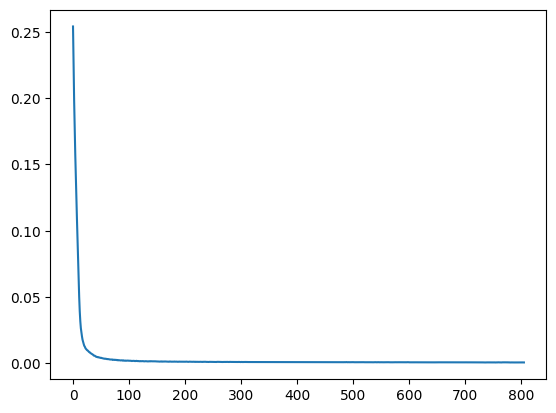

In [7]:
plt.plot(best_model['seq2seq_LSTM'][2])

In [8]:
label_y, predicted, first_label_y, first_predicted = predict_mtm(best_model['seq2seq_LSTM'][1], df, x_ss, y_ms, 1151, 7, 0.5, device)

94.84881162643433


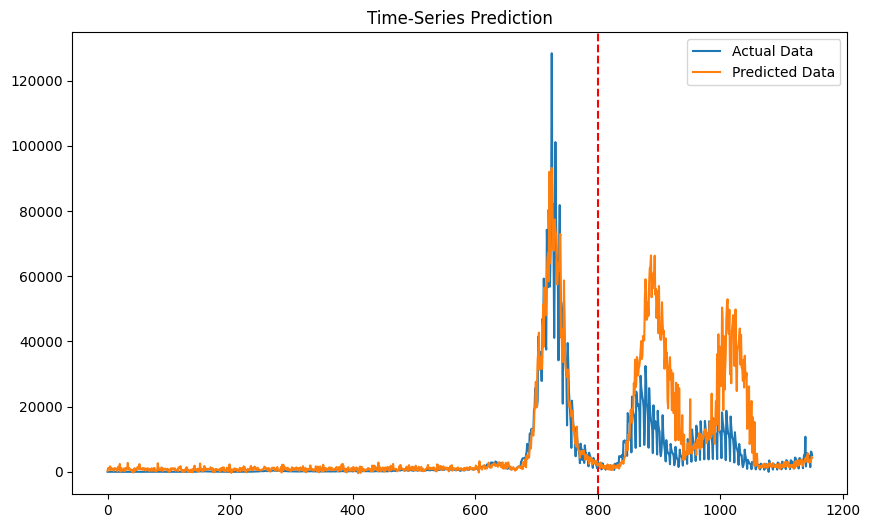

In [9]:
print(mape(label_y + 1, predicted))
plotting(first_label_y, first_predicted, 800)